In [1]:
from __future__ import annotations

import os
import random
import string

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display

%config InlineBackend.figure_format = 'svg'

In [2]:
DATA_PATH = 'reddit-L2/raw/reddit.{}.txt.tok.clean'
COUNTRIES_L1S = {
    'Greece': 'ELL', 
    'UK': 'ENG', 
    'US': 'ENG'
}

In [3]:
def file_to_df(
    file: str,
    *,
    mapping: dict[str, str] | None = None,
) -> pd.DataFrame:

    with open(file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if '[europe]' in line]
        users = [line.split(' ')[0] for line in lines]
        users = [user.removeprefix('[').removesuffix(']') for user in users]
        texts = [line.split(' ')[2:] for line in lines]
        texts = [" ".join(text) for text in texts]
        if mapping is not None:
            labels = [mapping[file.split('.', 2)[1]] for _ in lines]
        else:
            labels = [file.split('.', 2)[1] for _ in lines]

    df = pd.DataFrame({'user': users, 'text': texts, 'label': labels})
    return df

In [4]:
gr = file_to_df(DATA_PATH.format('Greece'), mapping=COUNTRIES_L1S)
uk = file_to_df(DATA_PATH.format('UK'), mapping=COUNTRIES_L1S)
us = file_to_df(DATA_PATH.format('US'), mapping=COUNTRIES_L1S)

In [5]:
for i, df in enumerate([gr, uk, us]):
    df.name = [k for k in COUNTRIES_L1S.keys()][i]
    max_len = max([len(country) for country in COUNTRIES_L1S.keys()])
    print(f"{df.name:>{max_len}}: {df.shape[0]:>{max_len}} posts", end="\n\n")
    display(df.sample(5))
    print()

Greece: 218857 posts



user                                               text  \
178742  Divide-By-Zero88  d ) The missiles were already there before the...   
16012        txapollo342  US and EU countries are together in the scanda...   
85126             TheoGr  But how can one tell people who are opposed to...   
166678            TheoGr  you can make an observation , comment or quest...   
39902              vitge  [ Yeah , okay ] ( http://media2.giphy.com/medi...   

       label  
178742   ELL  
16012    ELL  
85126    ELL  
166678   ELL  
39902    ELL


    UK: 1128128 posts



user                                               text  \
430227               Taure  Most importantly , it was never a jointly agre...   
308096  MasterOfWhisperers  > And nobody can say if it is effective , test...   
297678                   _  _] [europe] > Just because they can justify th...   
654111          Trucidator         Obviously , the EU might not accept this .   
171510        LordAnubis12  I 'm not really interested in clubbing etc , s...   

       label  
430227   ENG  
308096   ENG  
297678   ENG  
654111   ENG  
171510   ENG


    US: 715101 posts



user                                               text  \
359439             AyyMane  > ______________________________________ > Eur...   
365552  Le_Euphoric_Genius  If they did then using that quote is a bit dis...   
241668           Overgoats  It 's a combination of ludicrous portion size ...   
674999    TheNaughtyMonkey                       We just do it really badly .   
278821              koleye  You would end up with something that looks ver...   

       label  
359439   ENG  
365552   ENG  
241668   ENG  
674999   ENG  
278821   ENG

In [6]:
gr.shape, uk.shape, us.shape

((218857, 3), (1128128, 3), (715101, 3))

In [44]:
# Get the range of the number of words in each df
gr_len = gr['text'].apply(lambda x: len(x.split()))
uk_len = uk['text'].apply(lambda x: len(x.split()))
us_len = us['text'].apply(lambda x: len(x.split()))

# make boxplots in a single figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([gr_len, uk_len, us_len], labels=[k for k in COUNTRIES_L1S.keys()])
ax.set_title('Number of words in texts')
ax.set_ylabel('Number of words')
ax.set_xlabel('Country')
plt.grid(zorder=0, alpha=0.25)
plt.show();

In [8]:
for length in [100, 250, 500, 1000]:
    print(f"Number of texts with less than {length} words:")
    for i, df in enumerate([gr, uk, us], start=1):
        print(f"df_{i}: {df[df['text'].apply(lambda x: len(x.split())) < length].shape[0]:>{max_len}} texts")
    print()

Number of texts with less than 100 words:
df_1: 218558 texts
df_2: 1127073 texts
df_3: 714122 texts

Number of texts with less than 250 words:
df_1: 218847 texts
df_2: 1128072 texts
df_3: 715049 texts

Number of texts with less than 500 words:
df_1: 218855 texts
df_2: 1128121 texts
df_3: 715091 texts

Number of texts with less than 1000 words:
df_1: 218856 texts
df_2: 1128127 texts
df_3: 715099 texts



In [9]:
for length in [2000, 1000, 500, 250, 100, 50]:
    print(f"Number of texts with more than {length} words:")
    for i, df in enumerate([gr, uk, us], start=1):
        print(f"df_{i}: {df[df['text'].apply(lambda x: len(x.split())) > length].shape[0]:>{max_len}} texts")
    print()

Number of texts with more than 2000 words:
df_1:      0 texts
df_2:      0 texts
df_3:      0 texts

Number of texts with more than 1000 words:
df_1:      1 texts
df_2:      1 texts
df_3:      2 texts

Number of texts with more than 500 words:
df_1:      2 texts
df_2:      7 texts
df_3:     10 texts

Number of texts with more than 250 words:
df_1:     10 texts
df_2:     56 texts
df_3:     51 texts

Number of texts with more than 100 words:
df_1:    283 texts
df_2:   1018 texts
df_3:    934 texts

Number of texts with more than 50 words:
df_1:   4589 texts
df_2:  24079 texts
df_3:  16244 texts



> We can see that in the Greek dataset there are approx. 4,500 texts with at least 50 words. We will use this as a threshold.

In [10]:
gr_final = gr[(gr['text'].apply(lambda x: len(x.split())) >= 50) & (gr['text'].apply(lambda x: len(x.split())) <= 200)]
uk_final = uk[(uk['text'].apply(lambda x: len(x.split())) >= 50) & (uk['text'].apply(lambda x: len(x.split())) <= 200)]
us_final = us[(us['text'].apply(lambda x: len(x.split())) >= 50) & (us['text'].apply(lambda x: len(x.split())) <= 200)]

In [11]:
# Merge UK and US dfs and take a subset equal to the Greek dataframe
en_final = pd.concat([uk_final, us_final])
en_final = en_final.sample(n=gr_final.shape[0], random_state=42)
en_final.shape, gr_final.shape

((4944, 3), (4944, 3))

In [12]:
# Merge the Greek and English dataframes (add a column for the language)
df = (pd
        .concat([gr_final, en_final])
        .reset_index(drop=True)
    )

In [13]:
df

user                                               text  \
0                 gschizas  It 's 1 & # 160 ; & #x 20ac ; = 340,75 & # 160...   
1             neutrolgreek  The economy bottomed out in 2013 and is now st...   
2          NYGreenandwhite  Ah yes PASOK , the party formerly run by IMF E...   
3                Petros557  67-73 : military coup , the leftists are hunte...   
4             neutrolgreek  I 've explained this to you before but I will ...   
...                    ...                                                ...   
9883           apple_kicks  Recall hearing tories do n't like it when some...   
9884               Frankeh  Stuff like this makes me wonder . . Can ultra ...   
9885        chrisawhitmore  No , they voted to leave because they noted th...   
9886  dances_with_unicorns  I have been living in Europe ( on the `` insid...   
9887               nounhud  This is actually an area that may deserve seri...   

     label  
0      ELL  
1      ELL  
2      ELL  
3      ELL  
4      ELL  
...    ...  
9883   ENG  
9884   ENG  
9885   ENG  
9886   ENG  
9887   ENG  

[9888 rows x 3 columns]

In [14]:
for label in df['label'].unique():
    n_texts = df[df['label'] == label].shape[0]
    n_users = df[df['label'] == label]['user'].nunique()
    print(f"{label}: {n_texts} texts by {n_users} users")

ELL: 4944 texts by 300 users
ENG: 4944 texts by 1163 users


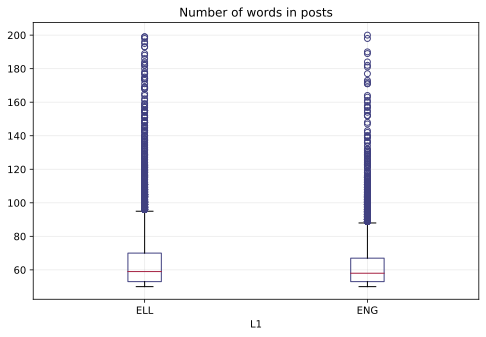

In [43]:
# Get the range of the number of words in each df
el_len = df[df['label'] == 'ELL']['text'].apply(lambda x: len(x.split()))
en_len = df[df['label'] == 'ENG']['text'].apply(lambda x: len(x.split()))

# make boxplots in a single figure
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot([el_len, en_len], labels=df['label'].unique().tolist())
ax.set_title('Number of words in posts')
ax.set_xlabel('L1')
plt.grid(zorder=0, alpha=0.25)
plt.show();

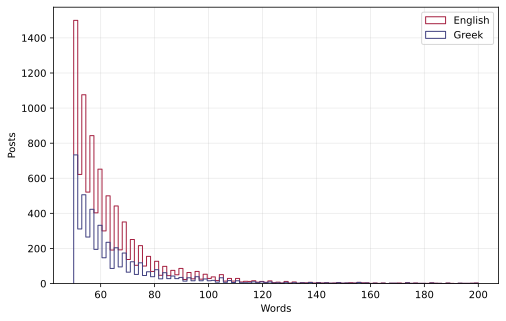

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist([el_len, en_len], bins=100, label=['Greek', 'English'], color=['#404080', '#a52040'], histtype='step', stacked=True)
ax.set_xlabel('Words')
ax.set_ylabel('Posts')
ax.legend()
plt.grid(zorder=0, alpha=0.25)
plt.show();

In [58]:
# Anonymize the users by assigning a random string to each user
def random_string(length: int = 6) -> str:
    random_id = [random.choice(string.hexdigits) for _ in range(length)]
    return "".join(random_id).lower()

all_users = df['user'].unique()
df['user_id'] = df['user'].map({user: random_string(10) for user in all_users})

In [59]:
df.head(10)

user                                               text label  \
0         gschizas  It 's 1 & # 160 ; & #x 20ac ; = 340,75 & # 160...   ELL   
1     neutrolgreek  The economy bottomed out in 2013 and is now st...   ELL   
2  NYGreenandwhite  Ah yes PASOK , the party formerly run by IMF E...   ELL   
3        Petros557  67-73 : military coup , the leftists are hunte...   ELL   
4     neutrolgreek  I 've explained this to you before but I will ...   ELL   
5     neutrolgreek  The difference is that Greece fulfills and exc...   ELL   
6     neutrolgreek  Throughout , Greece has remained an active and...   ELL   
7        Petros557  fun fact : the current prime minister ( samara...   ELL   
8        Petros557  the reason capitalism has been failing in thes...   ELL   
9     neutrolgreek  [ Trans Adriatic Pipeline AG \ ( TAP \ ) has i...   ELL   

      user_id  
0  ebc2c3fefe  
1  1ddb4e0097  
2  cd6fd1fe3c  
3  bfe245e3ef  
4  1ddb4e0097  
5  1ddb4e0097  
6  1ddb4e0097  
7  bfe245e3ef  
8  bfe245e3ef  
9  1ddb4e0097

In [60]:
df = df[['user_id', 'text', 'label']]
df = df.sort_values(by=['label', 'user_id']).reset_index(drop=True)
df.head(10)

user_id                                               text label
0  019b8b99bd  The fact that politicians can steal millions ,...   ELL
1  019b8b99bd  When an old man who sells chestnuts in the str...   ELL
2  019b8b99bd  `` New * Something * '' implies that colonists...   ELL
3  019b8b99bd  > It 's also even more funny that you claim to...   ELL
4  019b8b99bd  Ok , so the turks abducted countless Greek bab...   ELL
5  019b8b99bd  According to the recommendation , Balkan state...   ELL
6  019b8b99bd  > The range of different forms of identity and...   ELL
7  019b8b99bd  > It is honestly quite sad and pathetic how yo...   ELL
8  019b8b99bd  Also note that any claims of `` Greek propagan...   ELL
9  019b8b99bd  Their ancestors were Greeks who adopted the La...   ELL

In [61]:
df.to_csv("reddit_ell_eng_raw_200.csv", index=False, encoding='utf-8')